<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/PART4_CNN(1~3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **01. 합성곱 신경망(CNN)**
- 데이터가 가진 특징들의 패턴을 학습하는 알고리즘
- 대표적으로 이미지 분류, 객체 탐지, 스타일 전이 등 

## **1-1. 이미지 표현**
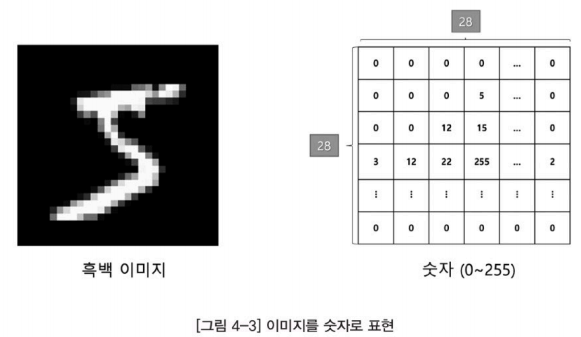
- 이미지를 0~255 사이의 숫자로 각 픽셀의 화소값을 나타내는 방식으로 표현해야 함 (0은 검은색, 255는 흰색)
- 숫자는 이미지의 강도를 나타내고, 숫자가 클수록 더 강한 특성을 나타냄
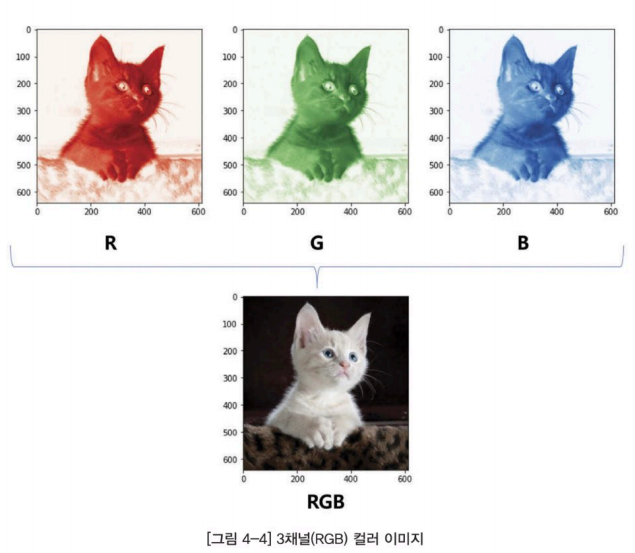
- 컬러 이미지는 R, G, B 채널로 구성된 3장의 이미지를 겹쳐서 표현
- 채널은 각각이 하나의 이미지로 구분됨

## **1-2. 합성곱(Convolution)**
- 합성곱 연산: 입력 이미지에 대하여 일반적으로 정방형 크기를 가지는 kernel을 사용하여, 입력 이미지에 대한 특성을 추출하는 방법
- 특성맵(feature map): 합성곱 연산을 통해서 추출된 이미지
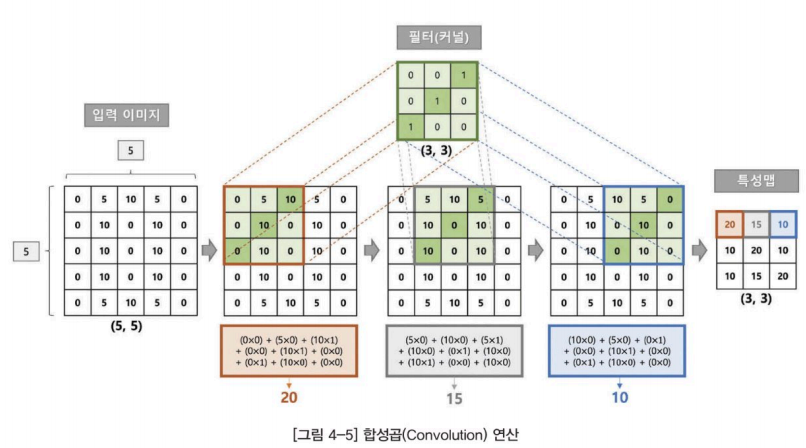

## **1-3. 채널(channel)**
- 입력 이미지를 구성하는 2차원 배열의 개수 
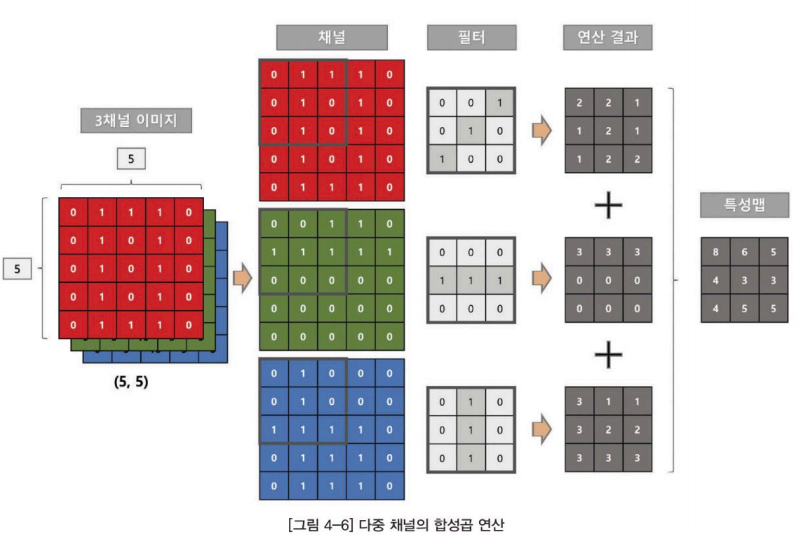

## **1-4. 스트라이드(stride)**
- 커널은 좌측 상단으로부터 입력 이미지를 기준으로 우측으로 이동하면서 합성곱 연산을 계속 수행하고 특성맵에 결과를 채워나감. 이때 이동하는 간격이 스트라이드. 주로 1 또는 2로 설정됨.
- 1로 설정 시 커널은 우측으로 1픽셀씩 이동하게 되며, 커널이 입력 이미지의 우측 끝까지 이동했다면 아래 방향으로 1칸 좌측 첫 번째 픽셀로 이동하여 추출함.
- 2로 설정 시 2픽셀 씩 건너뛰기 때문에 특성맵의 크기가 1/2로 줄어듬. 
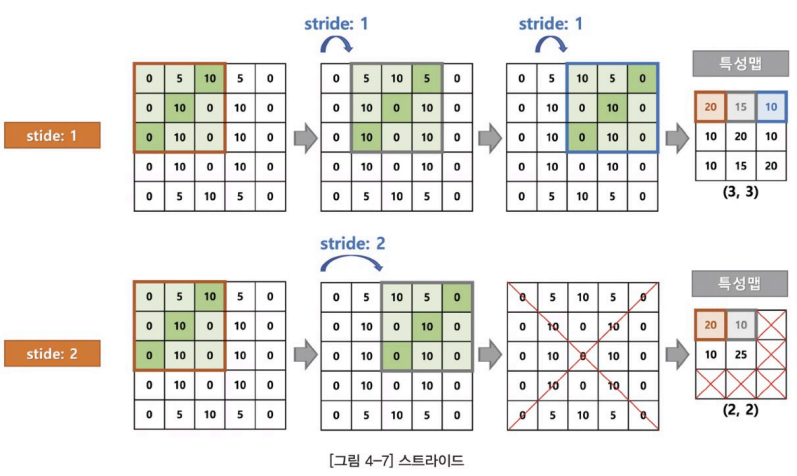

## **1-5. 패딩(padding)**
- 추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 하는 설정
- 일반적으로 zero-padding을 사용, 입력 이미지의 가장 자리에 0으로 채워진 패딩 값으로 채운 후 추출. 패딩을 적용 후 합성곱 연산을 수행하게 되면 특성맵의 크기가 줄어들지 않음
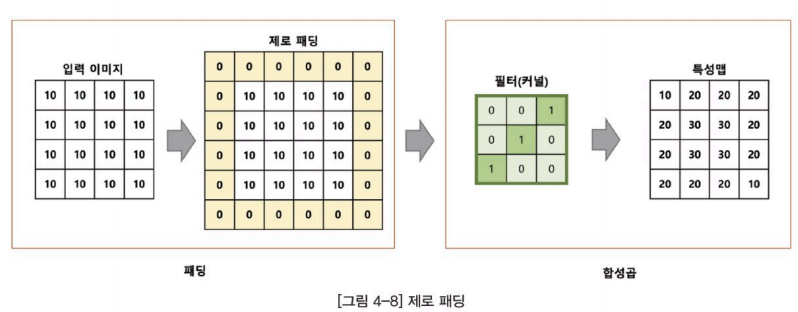

## **1-6. 특성맵(feature map) 사이즈**
- 패딩과 스트라이드를 적용하고, 입력 데이터와 필터의 크기가 주어졌을 때 출력 데이터의 크기를 구하는 식
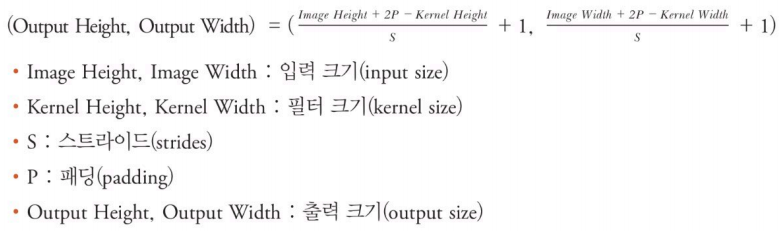


## **1-7. 풀링(pooling)**
- 풀링 레이어: 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어
- 이미지 축소를 통해 연산량을 감소한다는 점과 과대적합을 방지한다는 장점이 있음
- 최대 풀링(max pooling)과 평균 풀링(avrage pooling)으로 나뉨
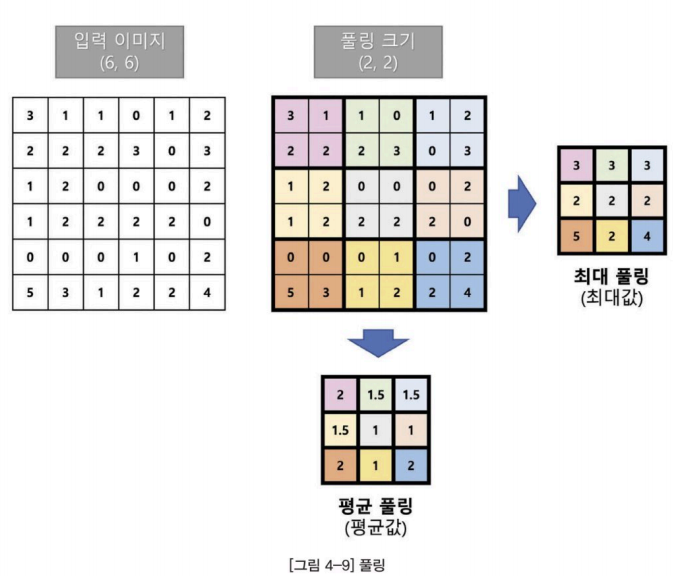

# **02. 간단한 모델 생성**

## **2-1. 데이터 로드 및 전처리**

In [2]:
# tensorflow 모듈 import 
import tensorflow as tf

In [5]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


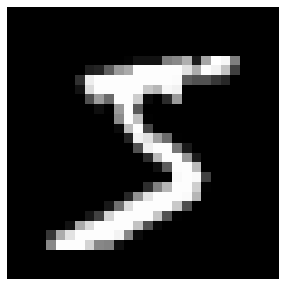

In [6]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap="gray")
    plt.axis("off")
    plt.show()

plot_image(x_train, 0)

In [7]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


- 딥러닝 모델의 안정적인 학습을 위해 입력 이미지 픽셀 값을 정규화 변환

In [8]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


- CNN 모델에 주입하기 위해 색상을 나타내는 채널 추가

In [9]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## **2-2. Sequential API로 모델 생성 및 학습**
- Sequential API를 사용하여 합성곱 레이어 1개, 풀링 레이어 1개를 적용하는 간단한 모델 생성
- 최종 분류기로 Dense 레이어를 적용하기 위해 Flatten 층을 추가하여 1차원 배열로 펼쳐줌.
- 합성곱은 Conv2D 레이어를 사용, (3,3) 크기의 서로 다른 32가지 종류의 커널 적용
- ReLU 활성화 함수를 적용
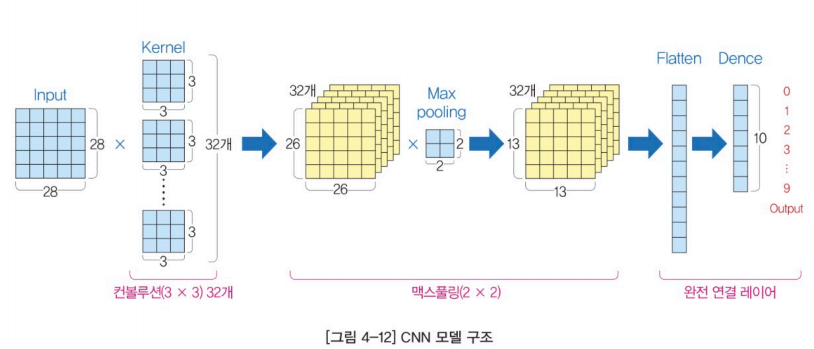
- 풀링 레이어는 (2,2) 크기로 최대 풀링을 적용, 레이어 이름 속성도 추가
- 최종 분류기는 정답 레이블이 0~9까지 10개의 값을 가지므로 노드 개수 10개, 분류 클래스가 10개인 다중 분류 문제이므로 활성화 함수로 softmax 적용 

In [10]:
# Sequential API를 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),
    # Classifier 출력층 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [11]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2195 - accuracy: 0.9383 - val_loss: 0.0863 - val_accuracy: 0.9754
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0815 - accuracy: 0.9765 - val_loss: 0.0712 - val_accuracy: 0.9769
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0609 - accuracy: 0.9819 - val_loss: 0.0589 - val_accuracy: 0.9808
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0502 - accuracy: 0.9850 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.0545 - val_accuracy: 0.9826
Epoch 6/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0495 - val_accuracy: 0.9845
Epoch 7/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.0502 -

In [12]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 2s 6ms/step - loss: 0.0541 - accuracy: 0.9846


[0.05411325767636299, 0.9846000075340271]

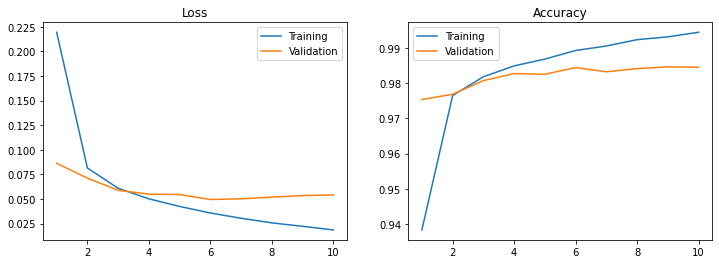

In [13]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

- 훈련 셋에 대한 손실은 계속 줄어드는데 검증 셋의 손실은 어느 수준에서 더 이상 낮아지지 않음
- 4 epoch 이후부터는 모델이 과대적합으로 진행되었다는 것을 파악할 수 있음

## **2-3. 모델 구조 파악**
- summary() 메소드를 적용해 주면 모델의 구조를 요약해서 보여줌
- (28,28,1) 형태의 입력 텐서가 Conv2D를 거치면서 (26,26,32) 형태로 변환됨. (3,3) 크기의 합성곱 필터를 사용하기 때문에 이미지 가로, 세로 크기가 2씩 줄어듬
- (2,2) 크기의 풀링 레이어를 적용했기 때문에 이미지 크기가 1/2로 줄어듬. 풀링 레이어를 거치면 (13,13,32) 텐서로 변환됨
- Flatten 층에서 3차원 텐서를 1차원 텐서로 펼치면 5408개 원소를 갖는 1차원 벡터가 됨
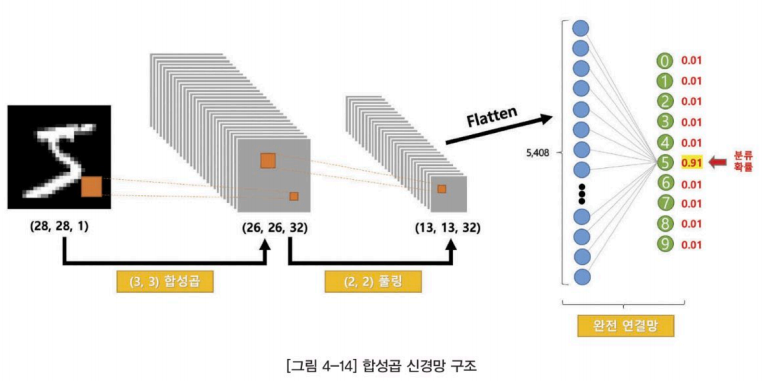

In [14]:
# 모델 구조 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 입력 텐서 형태 
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [16]:
# 출력 텐서 형태 
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>

In [17]:
# 레이어 
model.layers

In [18]:
# 첫번째 레이어 선택
model.layers[0]

In [19]:
# 첫번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [20]:
# 첫번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [21]:
# 첫번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.53334665,  0.07228226,  0.32234988,  0.2963601 ,
           -0.00393926, -0.02011885,  0.27380794,  0.08215323,
            0.16842282,  0.11454482, -0.26079383,  0.38044006,
           -1.2459232 , -0.56806403, -0.6095294 , -0.03311449,
           -0.00266281, -0.72359353,  0.29355466, -0.7604167 ,
            0.46145612,  0.0708897 ,  0.2503085 , -0.1997161 ,
            0.3571463 ,  0.2813179 , -1.2315042 , -0.8816042 ,
           -0.8187409 , -0.23172076, -0.3052494 ,  0.2882365 ]],
 
         [[-0.94221544,  0.37859726,  0.26861644,  0.16004884,
            0.50292116, -0.0177912 ,  0.258631  ,  0.35031658,
            0.24694693,  0.17190728,  0.01621873, -0.2395749 ,
           -0.94747925,  0.16519511,  0.43489912,  0.6536245 ,
            0.02322661,  0.03183791, -0.31766874, -0.17353041,
            0.18867783,  0.43586093,  0.05671212, -0.27882078,
            0.2623651 , -0.45747918, -0.85

In [22]:
# 첫번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-0.53334665,  0.07228226,  0.32234988,  0.2963601 ,
          -0.00393926, -0.02011885,  0.27380794,  0.08215323,
           0.16842282,  0.11454482, -0.26079383,  0.38044006,
          -1.2459232 , -0.56806403, -0.6095294 , -0.03311449,
          -0.00266281, -0.72359353,  0.29355466, -0.7604167 ,
           0.46145612,  0.0708897 ,  0.2503085 , -0.1997161 ,
           0.3571463 ,  0.2813179 , -1.2315042 , -0.8816042 ,
          -0.8187409 , -0.23172076, -0.3052494 ,  0.2882365 ]],

        [[-0.94221544,  0.37859726,  0.26861644,  0.16004884,
           0.50292116, -0.0177912 ,  0.258631  ,  0.35031658,
           0.24694693,  0.17190728,  0.01621873, -0.2395749 ,
          -0.94747925,  0.16519511,  0.43489912,  0.6536245 ,
           0.02322661,  0.03183791, -0.31766874, -0.17353041,
           0.18867783,  0.43586093,  0.05671212, -0.27882078,
           0.2623651 , -0.45747918, -0.8589477 ,  0.203582

In [23]:
# 첫번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.0089574 ,  0.0018907 , -0.46735665, -0.35949028, -0.05565003,
        0.        , -0.12276354, -0.25258762, -0.1934641 , -0.2876968 ,
       -0.23163116, -0.5051218 , -0.00305256, -0.21740012, -0.15677926,
        0.09182511, -0.10764223, -0.15633123, -0.3782551 , -0.14233434,
       -0.08579117, -0.09762454, -0.36739975,  0.00410432, -0.33456528,
       -0.3230834 ,  0.18054557, -0.04376042, -0.04601559, -0.06045176,
       -0.18182817, -0.3842726 ], dtype=float32)>

In [24]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

In [25]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가 (첫번째, 두번째 레이어)
activator = tf.keras.Model(inputs=model.input, 
                           outputs=[layer.output for layer in model.layers[:2]] ) 
activations = activator.predict(x_train_in[0][tf.newaxis, ...]) 

len(activations)

2

In [26]:
# 첫 번째 레이어(conv) 출력층 
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

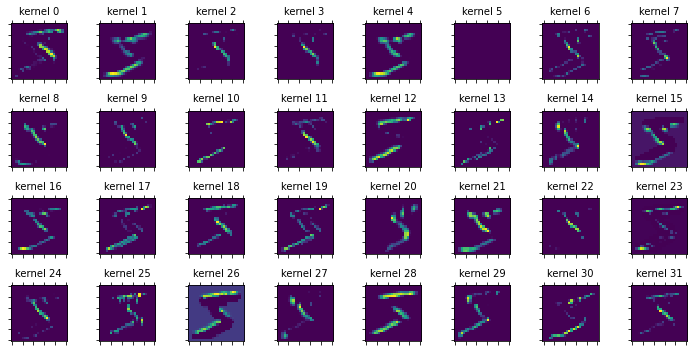

In [27]:
# Convolution 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [28]:
# 두 번째 레이어(pool) 출력층 
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


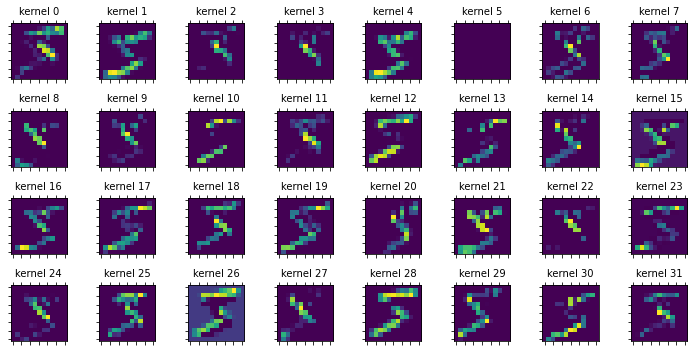

In [29]:
# 시각화
fig, axes = plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp( axes[i//8, i%8].get_xticklabels(), visible=False)
    plt.setp( axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# **03. 복잡한 모델 생성**
- Functional API로 복잡한 구조의 모델 정의 가능

## **3-1. 데이터셋 준비**

In [30]:
import tensorflow as tf
import numpy as np

In [31]:
# MNIST 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


- 0~9까지 숫자를 맞추는 정답 외에 홀수인지 짝수인지를 판단하는 정답(y_odd)을 새로 만들어서 추가
- y_train 값이 홀수면 1, 짝수면 0으로 하는 y_train_odd 배열을 새로 만듬
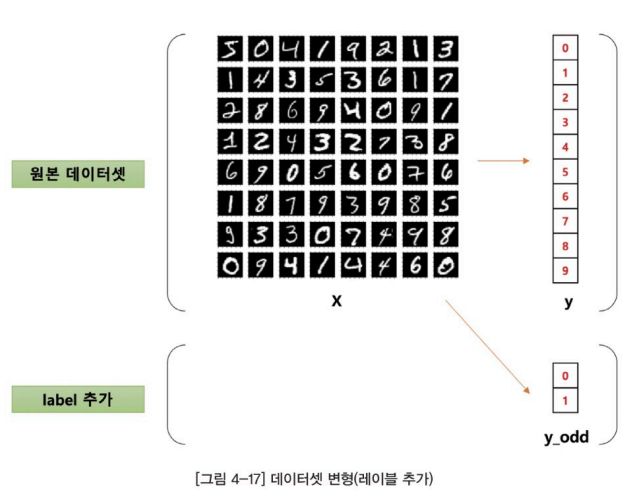

In [32]:
# 새로운 출력값 배열을 생성 (홀수: 1, 짝수: 0)
y_train_odd = []
for y in y_train:
    if y % 2==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [33]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [34]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [35]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## **3-2. Functional API로 다중 입력, 다중 출력 레이어 생성**

In [36]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_2 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

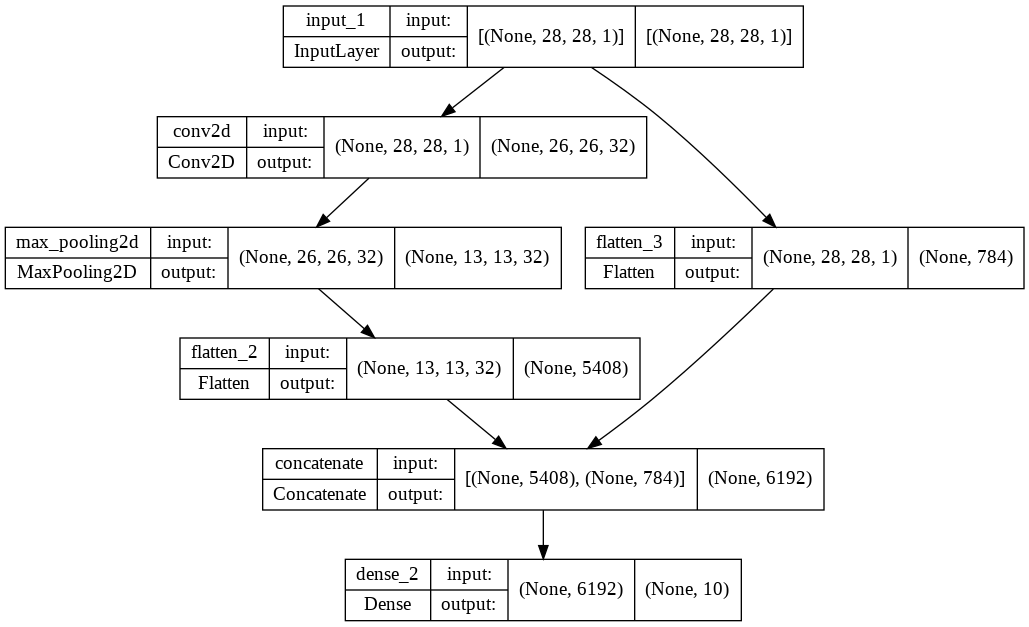

In [40]:
# 모델 구조 출력 및 이미지 파일로 저장
#from tensorflow.python.keras.layers import wrappers
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [41]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2045 - accuracy: 0.9413 - val_loss: 0.0855 - val_accuracy: 0.9728
Epoch 2/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0771 - accuracy: 0.9774 - val_loss: 0.0640 - val_accuracy: 0.9803
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0586 - accuracy: 0.9832 - val_loss: 0.0584 - val_accuracy: 0.9809
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0479 - accuracy: 0.9857 - val_loss: 0.0552 - val_accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0413 - accuracy: 0.9875 - val_loss: 0.0576 - val_accuracy: 0.9821
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0336 - accuracy: 0.9898 - val_loss: 0.0580 - val_accuracy: 0.9823
Epoch 7/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0596 -

## **3-3. 다중 출력 분류 모델**
- 두 가지 서로 다른 분류 문제를 예측하는 다중 출력 모델 생성
- 0~9까지 숫자를 맞추는 분류 문제와 홀수, 짝수를 맞추는 분류 문제를 동시에 풀어내는 모델을 정의
- 각기 다른 문제에 맞도록 최종 분류기의 출력 레이어를 2개 만드는 것이 핵심 
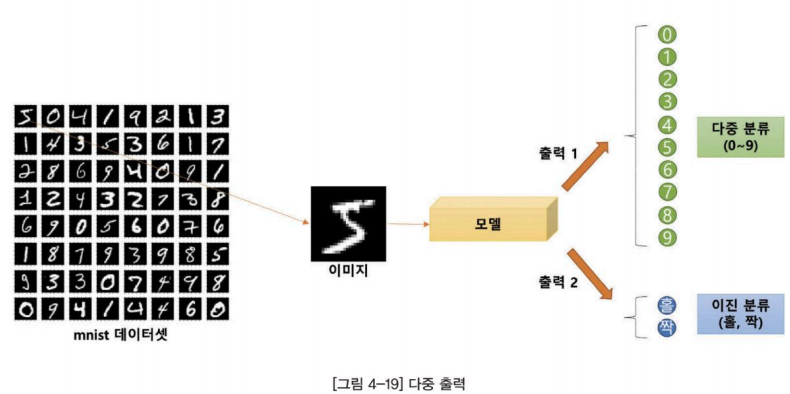

In [42]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

In [43]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


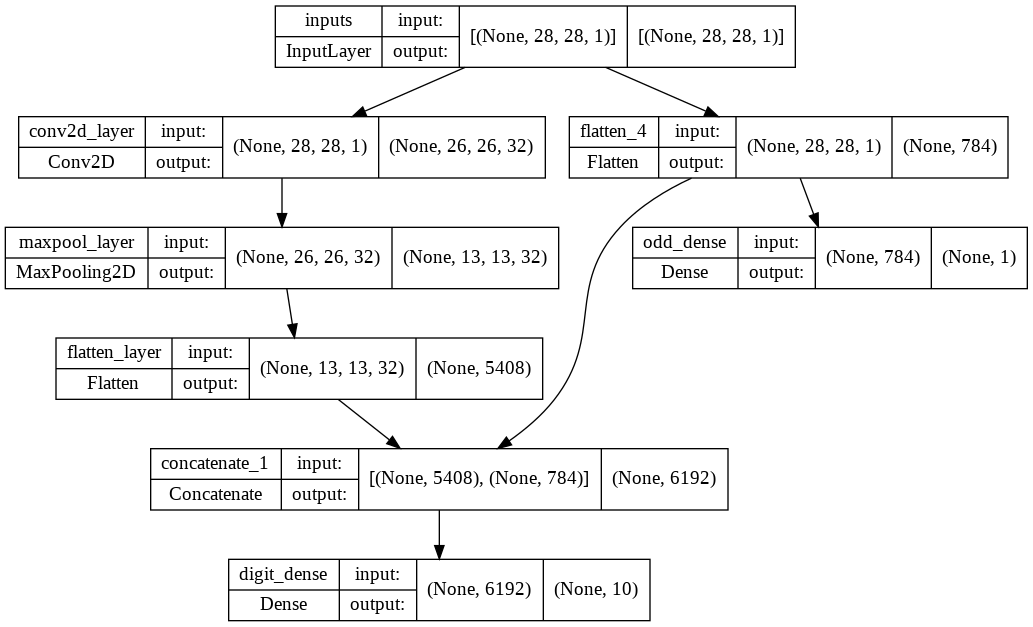

In [44]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [45]:
# 모델 컴파일
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'}, 
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs': x_train_in}, {'digit_dense': y_train, 'odd_dense': y_train_odd}, 
                    validation_data=({'inputs': x_valid_in},  {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3569 - digit_dense_loss: 0.1952 - odd_dense_loss: 0.3234 - digit_dense_accuracy: 0.9438 - odd_dense_accuracy: 0.8653 - val_loss: 0.2284 - val_digit_dense_loss: 0.0908 - val_odd_dense_loss: 0.2752 - val_digit_dense_accuracy: 0.9720 - val_odd_dense_accuracy: 0.8877
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2149 - digit_dense_loss: 0.0791 - odd_dense_loss: 0.2717 - digit_dense_accuracy: 0.9772 - odd_dense_accuracy: 0.8912 - val_loss: 0.2035 - val_digit_dense_loss: 0.0717 - val_odd_dense_loss: 0.2636 - val_digit_dense_accuracy: 0.9772 - val_odd_dense_accuracy: 0.8965
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1927 - digit_dense_loss: 0.0612 - odd_dense_loss: 0.2630 - digit_dense_accuracy: 0.9817 - odd_dense_accuracy: 0.8957 - val_loss: 0.1910 - val_digit_dense_loss: 0.0611 - val_odd_dense_loss: 0.2599 - val_digit_dense_accuracy: 0.9800 -

In [47]:
# 모델 성능
model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})

313/313 [==============================] - 2s 7ms/step - loss: 0.1909 - digit_dense_loss: 0.0629 - odd_dense_loss: 0.2561 - digit_dense_accuracy: 0.9837 - odd_dense_accuracy: 0.9019


[0.19088667631149292,
 0.06286118924617767,
 0.2560509443283081,
 0.9836999773979187,
 0.9018999934196472]

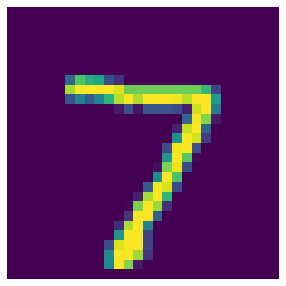

In [48]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

plot_image(x_valid, 0)

In [49]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

[1.3218329e-12 2.4326263e-10 4.6211079e-09 5.9564638e-07 1.4884746e-12
 1.8559863e-13 2.5447325e-20 9.9999940e-01 5.4294680e-10 2.9548419e-09]
[0.9994968]


In [50]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [51]:
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

## **3-4. 전이 학습(Transfer Learning)**
- 기존에 학습된 모델을 활용해 새로운 모델을 만들어 내는 개념
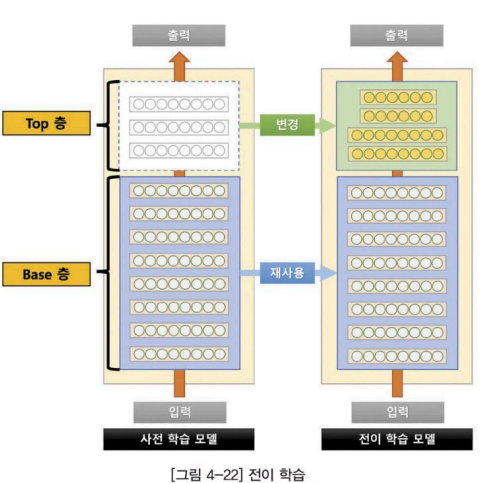

In [52]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


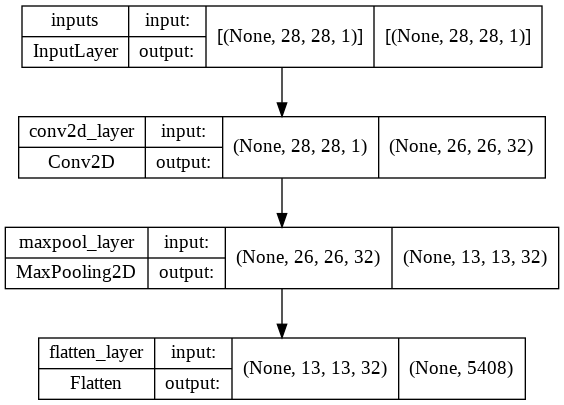

In [53]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [54]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                   base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),
                                   ])
digit_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


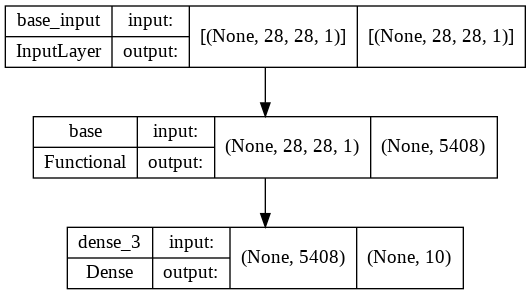

In [55]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [56]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1298 - accuracy: 0.9635 - val_loss: 0.0677 - val_accuracy: 0.9796
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0585 - accuracy: 0.9820 - val_loss: 0.0571 - val_accuracy: 0.9819
Epoch 3/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0453 - accuracy: 0.9860 - val_loss: 0.0505 - val_accuracy: 0.9830
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.0544 - val_accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0305 - accuracy: 0.9902 - val_loss: 0.0544 - val_accuracy: 0.9826
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0596 - val_accuracy: 0.9808
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 0.0685 -

In [57]:
# 베이스 모델의 가중치를 고정 (Freeze Model)

base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [58]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [59]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1183 - accuracy: 0.9683 - val_loss: 0.0614 - val_accuracy: 0.9813
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0497 - accuracy: 0.9853 - val_loss: 0.0541 - val_accuracy: 0.9833
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0370 - accuracy: 0.9895 - val_loss: 0.0532 - val_accuracy: 0.9829
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0291 - accuracy: 0.9912 - val_loss: 0.0484 - val_accuracy: 0.9841
Epoch 5/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.0510 - val_accuracy: 0.9835
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.0503 - val_accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 0.0611 - val_ac

In [60]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [61]:
# Functional API 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [62]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1174 - accuracy: 0.9679 - val_loss: 0.0595 - val_accuracy: 0.9802
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0500 - accuracy: 0.9855 - val_loss: 0.0509 - val_accuracy: 0.9831
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.0467 - val_accuracy: 0.9845
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0288 - accuracy: 0.9912 - val_loss: 0.0491 - val_accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0514 - val_accuracy: 0.9846
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0545 - val_accuracy: 0.9838
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.0533 - val_ac